In [256]:
import numpy as np
import matplotlib.pylab as pl
import ot
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from scipy.spatial import ConvexHull
from concave_hull import concave_hull, concave_hull_indexes
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance
import heapq
import random
from collections import deque
from scipy.spatial import distance
import networkx as nx
import random
from scipy.ndimage import gaussian_filter, binary_dilation, label, generate_binary_structure
from scipy.sparse.csgraph import minimum_spanning_tree
import cv2
from skimage import transform as tf
from scipy.spatial import KDTree
import os
from skimage.morphology import skeletonize
from skimage.draw import disk

# Ici on mettre a première partie de code qui permet de pré traiter la vidéo :
Gif -> images
image0 -> grille utilisable pour le RD simulator\
Là j'ai juste mis un exemple, on part d'un grille déjà construire hors de ce dossier pour le moment

# Reaction-Diffusion Simulator

In [257]:
!./main

Generation du pattern via RD


# Traitement de la grille obtenue après génération du pattern

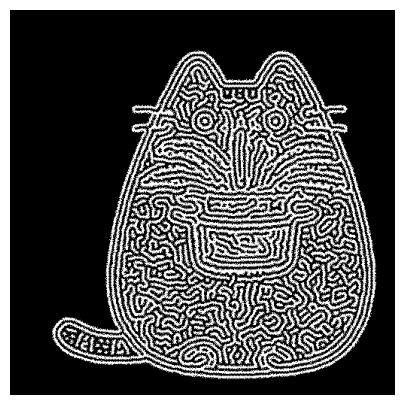

In [258]:
def load_grid(csv_path):
    return pd.read_csv(csv_path, header=None).values

def save_to_csv(grid, file_path):
    df = pd.DataFrame(grid)
    df.to_csv(file_path, header=False, index=False)

    

csv_path = 'test.csv'
grille = load_grid(csv_path)

plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(grille, cmap='gray')
plt.show()

La fonction setup fait trois choses : \
 -On lisse l'image pour éliminer les pixels qui trainent \
 -On binairise l'image pour passer à des pixels valant 0 ou 1 \
 -On transforme chaque mur en une ligne d'un pixel d'épaisseur

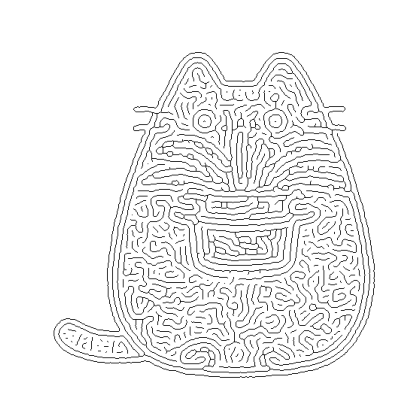

In [259]:
def setup(g):
    grille_lissée = gaussian_filter(g.astype(float), sigma=1)
    grille_binaire =(grille_lissée > 0.5).astype(int)
    grille_binaire=1-skeletonize(grille_binaire)
    return grille_binaire


grille_binaire=setup(grille)

plt.figure(figsize=(5, 5))
plt.imshow(grille_binaire, cmap='gray')
plt.axis('off')
plt.show()

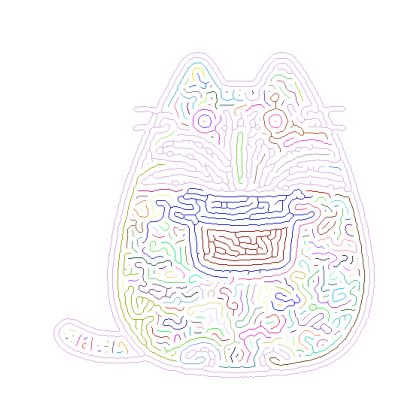

In [271]:
grid=1-grille_binaire  #on doit inverser

structure = generate_binary_structure(2, 2)  # structure de connexion 8-connexité

labeled_grid, num_features = label(grid, structure=structure) # Identifier les objets dans la grille

labeled_grid_3d = np.zeros((grid.shape[0], grid.shape[1], 3), dtype=np.uint8) # matrice 3D pour enregistrer à quelle ligne appartient chaque point


colors = {}
for i in range(1, num_features + 1):  # une couleur par ligne
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    colors[i] = color
    labeled_grid_3d[labeled_grid == i] = color


plt.figure(figsize=(5, 5))
plt.imshow(255-labeled_grid_3d)  # 255- pour afficher sur fond blanc
plt.axis('off')
plt.show()


# Déplacement des pixels

On charge l'image initiale f0, puis l'image f{i} qui correspond à la grille traitée depuis le début

In [272]:
f0 = cv2.imread('f0.png', cv2.IMREAD_GRAYSCALE)
f1 = cv2.imread('f0.png', cv2.IMREAD_GRAYSCALE)

Calcul du flux optique entre les images \
Ensuite on determine le plan de transport \
Et on remap la grille

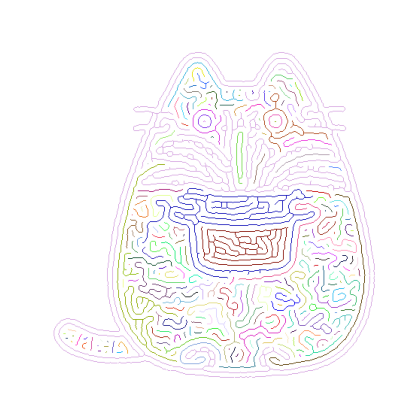

In [273]:
flow = cv2.calcOpticalFlowFarneback(f0, f1, None, 0.5, 3, 15, 3, 5, 1.2, 0)

# Carte pour les coordonnees de destination
h, w = flow.shape[:2]
flow_map_x, flow_map_y = np.meshgrid(np.arange(w), np.arange(h))
flow_map = np.dstack((flow_map_x, flow_map_y)).astype(np.float32) + flow



moved_grid = np.zeros_like(labeled_grid_3d)

for y in range(h):
    for x in range(w):
        new_x = int(flow_map[y, x, 0])
        new_y = int(flow_map[y, x, 1])
        if 0 <= new_x < w and 0 <= new_y < h:
            moved_grid[new_y, new_x] = labeled_grid_3d[y, x]


plt.figure(figsize=(5,5))
plt.imshow(255-moved_grid)
plt.axis('off')
plt.show()

On voit que cela a brisé pas mal de lignes, normal, la transformation est, dans ce cas, injective, donc certains points de destination ne sont pas remplis.\
Il faut desormais s'assurer que les lignes soient totalement reliées !\
Là c'est plutôt pas mal, la méthode employée est vraimmmment pas opti mais pas grave

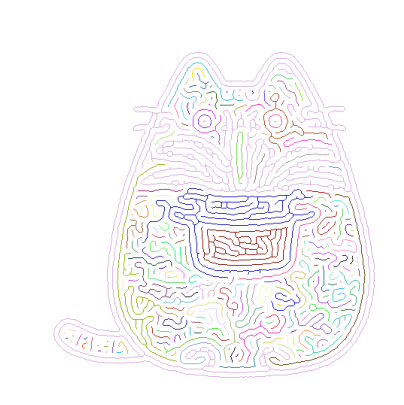

In [274]:
def connect_broken_lines(moved_grid):
    unique_colors = np.unique(moved_grid.reshape(-1, moved_grid.shape[2]), axis=0)
    unique_colors = unique_colors[np.any(unique_colors != [0, 0, 0], axis=1)]  # on vire les pixels noirs

    for color in unique_colors:
        mask = np.all(moved_grid == color, axis=-1)  # masque pour la couleur actuelle ca permet de garder juste les pixels qu'on veut
        points = np.argwhere(mask)

        if len(points) > 1:
            tree = KDTree(points)  # KDTree pour trouver les distances entre les points
            distances, indices = tree.query(points, k=len(points))

            # Créer une matrice de distances
            distance_matrix = np.zeros((len(points), len(points)))
            for i in range(len(points)):
                for j in range(1, len(points)):
                    distance_matrix[i, indices[i, j]] = distances[i, j]


            mst = minimum_spanning_tree(distance_matrix).toarray() # oui oui on passe bien par un MST, j'avais prévenu que c'était pas opti :)

            # completer les lignes de l'arbre couvrant minimal
            for i in range(len(points)):
                for j in range(len(points)):
                    if mst[i, j] > 0:
                        point1 = points[i]
                        point2 = points[j]
                        rr, cc = drawLine(point1[0], point1[1], point2[0], point2[1])
                        moved_grid[rr, cc] = color

    return moved_grid




def drawLine(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    rr, cc = zip(*points)
    return rr, cc




connected_moved_grid = connect_broken_lines(moved_grid)
# ça met quelques secondes à s'executer c'est normal


plt.figure(figsize=(5, 5))
plt.imshow(255-connected_moved_grid)
plt.axis('off')
plt.show()

Il y a quelques trous à cause de la manière avec laquelle j'ai construit l'agorithme, on s'assure que les lignes de la même couleurs ne forment qu'un seul bloc, ce qui autorise des trous à certains endroits car malgré ces trous, le graphe formé des points de la même couleur reste connexe

# Rendre le labyrinthe résoluble

La c'est ce qu'il y a dans le notebook mazeSolver.ipynb \
On traite la grille obtenue pour en faire un labyrinthe puis on peut sauvegarder l'image \
Une fois que cette partie sera bien fonctionnelle ça sera interessant de la placer AVANT le déplacement des pixels pour ne pas avoir à répeter l'étape à chaque fois.

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


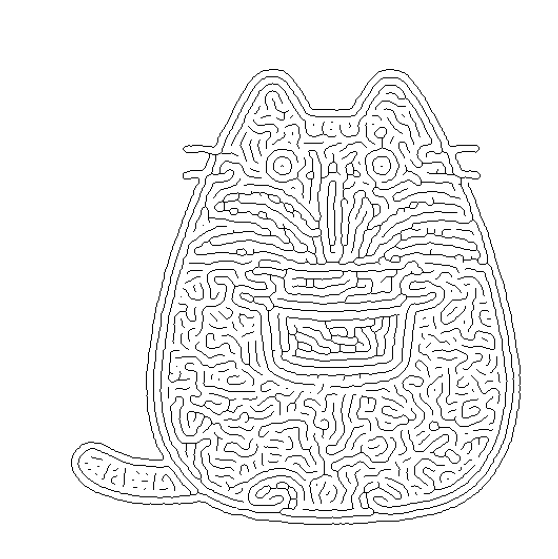

In [275]:
img = cv2.cvtColor(connected_moved_grid, cv2.COLOR_RGB2GRAY)
grille_binaire=1-(img > 0).astype(int)

print(grille_binaire)
plt.figure(figsize=(7, 7))
plt.imshow(grille_binaire, cmap='gray')
plt.axis('off')
plt.show()

On doit désormais remplir les trous dans le graphe

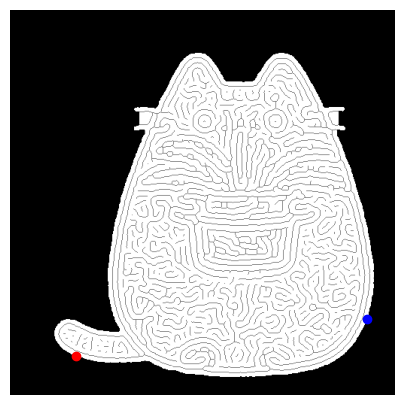

In [276]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Point, Polygon

def bresenham(x0, y0, x1, y1):
    """Implementation of Bresenham's line algorithm."""
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return points

grid = grille_binaire

points = np.column_stack(np.where(grid == 0))
convex_hull = ConvexHull(points)

length_threshold = 1
idxes = concave_hull_indexes(points, length_threshold=length_threshold) # non unicité à préciser
assert np.all(points[idxes] == concave_hull(points, length_threshold=length_threshold))

grid_clone = grid.copy()

for f, t in zip(idxes[:-1], idxes[1:]):
    seg = points[[f, t]]
    line_points = bresenham(int(seg[0][0]), int(seg[0][1]), int(seg[1][0]), int(seg[1][1]))
    for x, y in line_points:
        grid_clone[x, y] = 0

# Fermeture avec bresenham
if len(idxes) > 0:
    seg = points[[idxes[-1], idxes[0]]]
    line_points = bresenham(int(seg[0][0]), int(seg[0][1]), int(seg[1][0]), int(seg[1][1]))
    for x, y in line_points:
        grid_clone[x, y] = 0

start_point = points[np.random.choice(idxes)]
end_point = points[np.random.choice(idxes)]

'''
plt.subplot(1, 2, 1)
plt.imshow(grid, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(grid_clone, cmap='gray')

plt.scatter(start_point[1], start_point[0], color='red')
plt.scatter(end_point[1], end_point[0], color='blue')

plt.show()
'''

grid_clone[start_point[0], start_point[1]] = 1
grid_clone[end_point[0], end_point[1]] = 1


# polygone avec les points de l'enveloppe concave
hull_points = points[idxes]
polygon = Polygon(hull_points)

# Marquer l'exterieur
for x in range(grid.shape[0]):
    for y in range(grid.shape[1]):
        if not polygon.contains(Point(x, y)):
            grid_clone[x, y] = -1

plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(grid_clone, cmap='gray')
plt.scatter(start_point[1], start_point[0], color='red')
plt.scatter(end_point[1], end_point[0], color='blue')
plt.show()


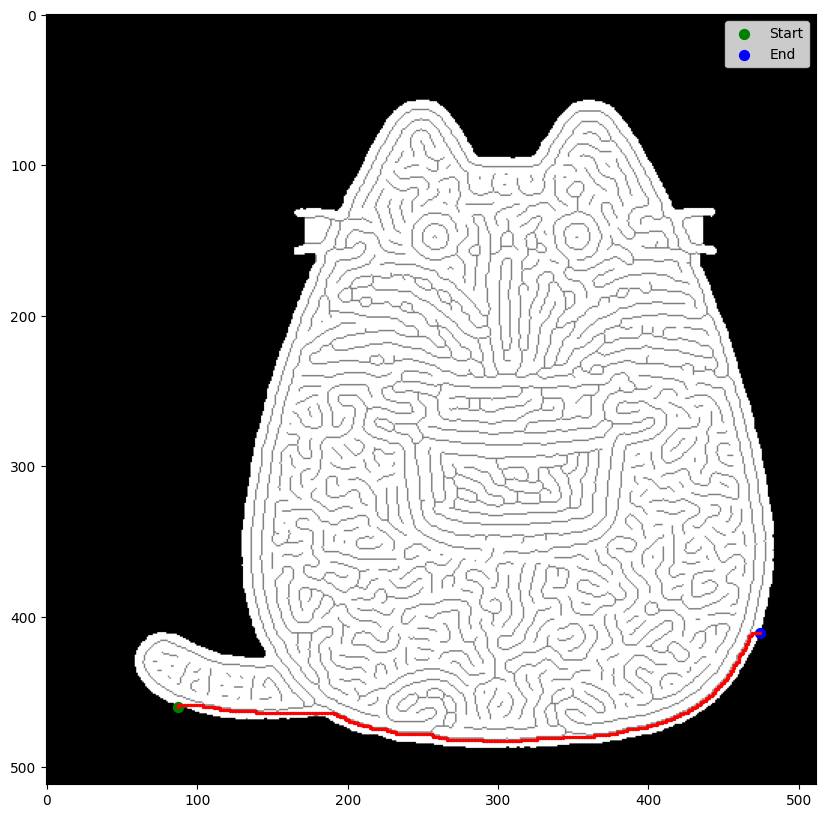

In [277]:
def is_valid_move(grid, x, y):
    rows = len(grid)
    cols = len(grid[0])
    return 0 <= x < rows and 0 <= y < cols and grid[x][y] == 1

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def astar(grid, start, end):
    rows, cols = len(grid), len(grid[0])
    start, end = tuple(start), tuple(end)
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, end)}
    
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    while open_set:
        _, current = heapq.heappop(open_set)
        
        if current == end:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]
        
        for direction in directions:
            neighbor = (current[0] + direction[0], current[1] + direction[1])
            if is_valid_move(grid, neighbor[0], neighbor[1]):
                tentative_g_score = g_score[current] + 1
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, end)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
    
    return None


def plot_grid_with_path(grid, path, start, end):
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='gray')
    
    plt.scatter(start[1], start[0], color='green', s=50, label='Start')
    plt.scatter(end[1], end[0], color='blue', s=50, label='End')
    
    for (x, y) in path:
        plt.scatter(y, x, color='red', s=2)
    
    plt.legend()
    plt.show()

#start_point=[300,220] #on sait que ça marche ces valeurs
#end_point=[300,250]
grid_clone[start_point[0], start_point[1]] = 1
grid_clone[end_point[0], end_point[1]] = 1
path = astar(grid_clone, (start_point[0],start_point[1]), (end_point[0],end_point[1]))

if path:
    plot_grid_with_path(grid_clone, path, start_point, end_point)
else:
    print("Aucun chemin trouvé.")


On a désormais un labyrinthe, avec un point de départ, d'arrivée, et un chemin entre les deux (faut juste faire en sorte que le chemin soit plus long mais on verra après) \
Maintenant comme on veut que le chemin choisi soit unique, on va relier tous les autres murs (mettre le pseudo code de l'algo 2)

194


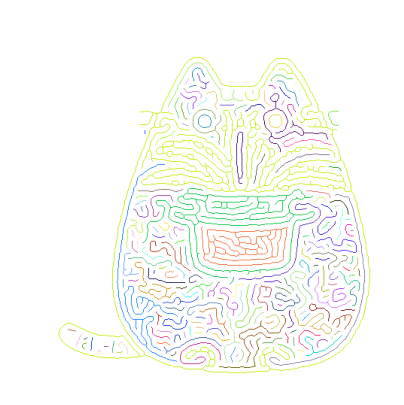

In [312]:
grid=grid_clone*grid_clone
grid=1-grid


structure = generate_binary_structure(2, 2)
labeled_grid, num_features = label(grid, structure=structure)
new_grid = np.copy(labeled_grid)

n_suppr=0
for i in range(1, num_features + 1):
    if np.sum(labeled_grid == i) < 4:
        new_grid[labeled_grid == i] = 0
        n_suppr+=1



labeled_grid_3d = np.zeros((grid.shape[0], grid.shape[1], 3), dtype=np.uint8)
colors = {}
for i in range(1, num_features + 1):
    if np.sum(labeled_grid == i) >= 4:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        colors[i] = color
        labeled_grid_3d[new_grid == i] = color


num_features=num_features-n_suppr
print(num_features)
plt.figure(figsize=(5, 5))
plt.imshow(255 - labeled_grid_3d)
plt.axis('off')
plt.show()

not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
not none
n

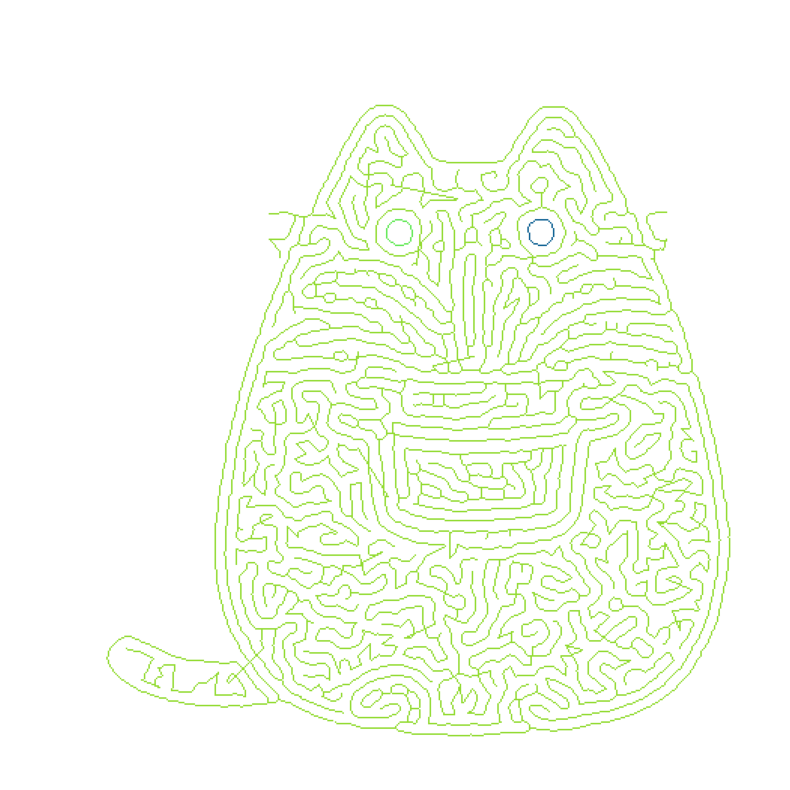

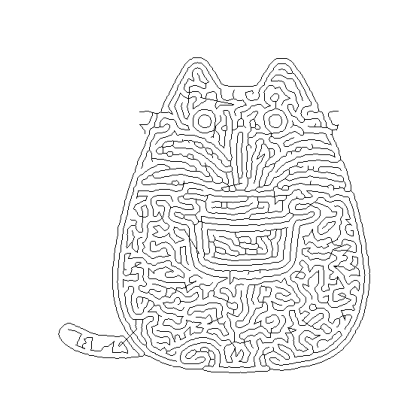

In [313]:
# attention dans cette version ça met 25min (vraiment) à compiler et ça fonctionne pas de ouf

def find_endpoints(label_grid, group_id):  #les extrémités de chaque groupe
    positions = np.column_stack(np.where(label_grid == group_id))
    endpoints = []
    for pos in positions:
        x, y = pos
        neighbors = label_grid[x-1:x+2, y-1:y+2] == group_id
        if np.sum(neighbors) <= 2: 
            endpoints.append((x, y))
    return endpoints

maze_path = path
iteration=0
def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def draw_line(grid, p1, p2, group_id):
    x1, y1 = p1
    x2, y2 = p2
    dx, dy = abs(x2 - x1), abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while True:
        if grid[x1, y1] == 0 and (x1, y1) not in maze_path:
            grid[x1, y1] = group_id
        if (x1, y1) == (x2, y2):
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

def can_draw_line(grid, p1, p2, maze_path, group1, group2): #voir si ça coupe rien
    x1, y1 = p1
    x2, y2 = p2
    dx, dy = abs(x2 - x1), abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while True:
        for nx in range(-1, 2):
            for ny in range(-1, 2):
                nx_x1 = x1 + nx
                ny_y1 = y1 + ny
                if (nx_x1, ny_y1) in maze_path or (0 <= nx_x1 < grid.shape[0] and 0 <= ny_y1 < grid.shape[1] and grid[nx_x1, ny_y1] > 0 and grid[nx_x1, ny_y1] != group1 and grid[nx_x1, ny_y1] != group2):
                    return False
        if (x1, y1) == (x2, y2):
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

    return True


start_num_features=num_features  #pour pouvoir modifier num_features pendant l'algo
for _ in range(start_num_features+30):

    random_group = random.choice([i for i in range(1, num_features + 1) if np.sum(labeled_grid == i) >= 4])
    endpoints = find_endpoints(labeled_grid, random_group)

    closest_group = None
    closest_endpoint_point = None
    min_distance = float('inf')

    for i in range(1, num_features + 1):
            if i != random_group and np.sum(labeled_grid == i) >= 4:
                other_endpoints = find_endpoints(labeled_grid, i)
                for endpoint_point in endpoints:
                    for other_point in other_endpoints:
                        if can_draw_line(labeled_grid, endpoint_point, other_point, maze_path, random_group, i):
                            dist = distance(endpoint_point, other_point)
                            if dist < min_distance:
                                min_distance = dist
                                closest_group = i
                                closest_endpoint_point = other_point
                                closest_random_endpoint = endpoint_point


        # connect the 2 groups
    if closest_group is not None:
        print('not none')
        draw_line(new_grid, closest_random_endpoint, closest_endpoint_point, random_group)
        new_grid[new_grid == closest_group] = random_group
        
        # Update labeled_grid and num_features to reflect the new state
        labeled_grid, num_features = label(new_grid, structure=structure)
            
        # make suree that the newly formed group has a color
        if random_group not in colors:
            colors[random_group] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            
        labeled_grid_3d[new_grid == random_group] = colors[random_group]




    # Enregistrer l'image dans le dossier 'out' sous le nom '1.png', '2.png', etc.
    if (iteration%15==0):
        i = cv2.cvtColor(labeled_grid_3d, cv2.COLOR_RGB2GRAY)
        gg=1-(i > 0).astype(int)
        g=1-gg  #on doit inverser

        structure = generate_binary_structure(2, 2)  # structure de connexion 8-connexité

        lg, nf = label(g, structure=structure) # Identifier les objets dans la grille

        lg3D = np.zeros((g.shape[0], g.shape[1], 3), dtype=np.uint8) # matrice 3D pour enregistrer à quelle ligne appartient chaque point


        colors = {}
        for i in range(1, nf + 1):  # une couleur par ligne
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            colors[i] = color
            lg3D[lg == i] = color

        output_dir = 'out'
        os.makedirs(output_dir, exist_ok=True)

        # Trouver un nom de fichier disponible
        filename = '1.png'
        i = 1
        while os.path.exists(os.path.join(output_dir, filename)):
            i += 1
            filename = f'{i}.png'

        # Enregistrer l'image
        plt.imsave(os.path.join(output_dir, filename), 255 - lg3D)
    iteration+=1




colors = {}
for i in range(1, num_features + 1):  # une couleur par ligne
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    colors[i] = color
    labeled_grid_3d[labeled_grid == i] = color



plt.figure(figsize=(10, 10))
plt.imshow(255 - labeled_grid_3d)
plt.axis('off')
plt.show()


img = cv2.cvtColor(labeled_grid_3d, cv2.COLOR_RGB2GRAY)
grille_binaire=1-(img > 0).astype(int)
plt.figure(figsize=(5, 5))
plt.imshow(grille_binaire, cmap='gray')
plt.axis('off')
plt.show()

Là on devrait avoir un labyrinthe bien séparé en deux parties

# On transforme le tout en gif

Petit bout de code pour enregister l'image obtenu et fabriquer un gif à la fin, cette partie est à changer mais pour l'instant ça dépanne\
nb: on peut passer par un filtre gaussien de coef 0.15 pour elargir les traits en gardant la structure, à voir si on a le temps

In [315]:
'''img = cv2.cvtColor(connected_moved_grid, cv2.COLOR_RGB2GRAY)

def generate_unique_filename(base_name, extension): #fait à l'arrache avec chatGPT, faudra programmer une boucle qui traite chaque image, puis assemble le gif. Pas dur mais à faire à la fin tranquille
    counter = 1
    while True:
        filename = f"{base_name}{counter}.{extension}"
        if not os.path.exists(filename):
            return filename
        counter += 1

unique_filename = generate_unique_filename("img", "png")

#cv2.imwrite(unique_filename, img)

#save_to_csv(1-(img > 0).astype(int),'remaped.csv')

plt.figure(figsize=(8,8))
plt.imshow(1-(img > 0).astype(int), cmap='gray')
plt.axis('off')
plt.show()'''


'img = cv2.cvtColor(connected_moved_grid, cv2.COLOR_RGB2GRAY)\n\ndef generate_unique_filename(base_name, extension): #fait à l\'arrache avec chatGPT, faudra programmer une boucle qui traite chaque image, puis assemble le gif. Pas dur mais à faire à la fin tranquille\n    counter = 1\n    while True:\n        filename = f"{base_name}{counter}.{extension}"\n        if not os.path.exists(filename):\n            return filename\n        counter += 1\n\nunique_filename = generate_unique_filename("img", "png")\n\n#cv2.imwrite(unique_filename, img)\n\n#save_to_csv(1-(img > 0).astype(int),\'remaped.csv\')\n\nplt.figure(figsize=(8,8))\nplt.imshow(1-(img > 0).astype(int), cmap=\'gray\')\nplt.axis(\'off\')\nplt.show()'